In [1]:
import skgstat as skg
import itertools
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.rk import Krige
from pykrige.compat import GridSearchCV
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colors

In [2]:
# parser function
def parser(fname):
    f = open(fname, "r")
    readings = []
    f.readline()
    f.readline()
    for line in f:
        temp = line.strip("\n").split()
        temp2 = [temp[0], int(temp[1]), float(temp[2]), float(temp[3]), float(temp[4]), float(temp[5]), float(temp[6])]
        readings.append(temp2)
    f.close()
    return readings

In [3]:
# parser function
def parser_log(fname):
    f = open(fname, "r")
    readings = []
    
    for line in f:
        temp = line.strip("\n").split(",")
                #datetime,lat,long,alt,vel_x,vel_y,vel_z,acc_x,elevation,
                    #source,location,vehicle,device,freq,sig_strength,sig_strength_Dbm
        temp2 = [temp[0], float(temp[1]), float(temp[2]), float(temp[3]), float(temp[4]), float(temp[5]), float(temp[6]), temp[7], float(temp[8]),
                    int(temp[9]), int(temp[10]), int(temp[11]), int(temp[12]), float(temp[13]), float(temp[14]), float(temp[15])]
        readings.append(temp2)
    f.close()
    return readings

In [4]:
def extract(arr, ind):
    temp = []
    for i in arr:
        temp.append(i[ind])
        
    return temp

In [5]:
# populate data

# ID, Loop#, Timestamp, Freq, Lat, Long, RF reading
readings = parser_log("../data/channel14_470mhz.log")


In [6]:
#lats = np.array(extract(readings,4))
#long = np.array(extract(readings,5))
#rf_freqs = np.array(extract(readings,6))
lats = extract(readings,1)
long = extract(readings, 2)
alt = extract(readings, 3)
rf_freqs = extract(readings, 15)

In [7]:
minlat = min(lats)
maxlat = max(lats)
minlong = min(long)#-116.65
maxlong = max(long)
lat_mesh = np.arange(minlat,maxlat,abs(minlat-maxlat)/100)
long_mesh=np.arange(minlong,maxlong,abs(minlong-maxlong)/100)

In [8]:
len(long_mesh)

100

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'exponential' Variogram Model
Partial Sill: 2.9151898999436163
Full Sill: 8.320327082028694
Range: 4.9430680119241896e-05
Nugget: 5.4051371820850775 



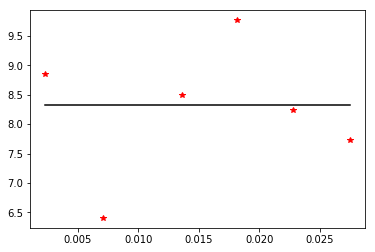

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [13]:
# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.

#example:
# OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], 
            #variogram_model='linear', verbose=False, enable_plotting=False)

OK = OrdinaryKriging(lats, long, rf_freqs, variogram_model='exponential',
                     verbose=True, enable_plotting=True, coordinates_type='geographic')
z, ss = OK.execute('grid', lat_mesh, long_mesh)

#### universal kriging

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 2.715789343662278
Full Sill: 8.360513083482374
Range: 4.775638192815483e-07
Nugget: 5.644723739820095 



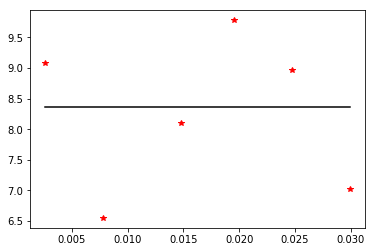

Calculating statistics on variogram model fit...
Q1 = 0.4881791108207835
Q2 = 0.8831187753601052
cR = 7.402419564006663 

Initializing drift terms...
Executing Universal Kriging...



In [12]:
UK = UniversalKriging(lats, long, rf_freqs, variogram_model='exponential',
                     verbose=True, enable_plotting=True)
zo, sso = UK.execute('grid', lat_mesh, long_mesh)

In [14]:
minn = 0
maxx = -1000
for i in zo:
    tmpmin=min(i.data)
    if tmpmin < minn:
        minn=tmpmin
    tmpmax = max(i.data)
    if tmpmax > maxx:
        maxx=tmpmax

In [15]:
len(z)

100

In [16]:
print(minn)
print(maxx)
print(min(rf_freqs))
print(max(rf_freqs))

-65.70059027947799
-65.70058812321628
-86.7624022665
-59.068270098


In [44]:
ls = [-125.995354, -109.74596445615346, -105.88484194949307 -90.233002]

(-116.65, -116.63458025694369)

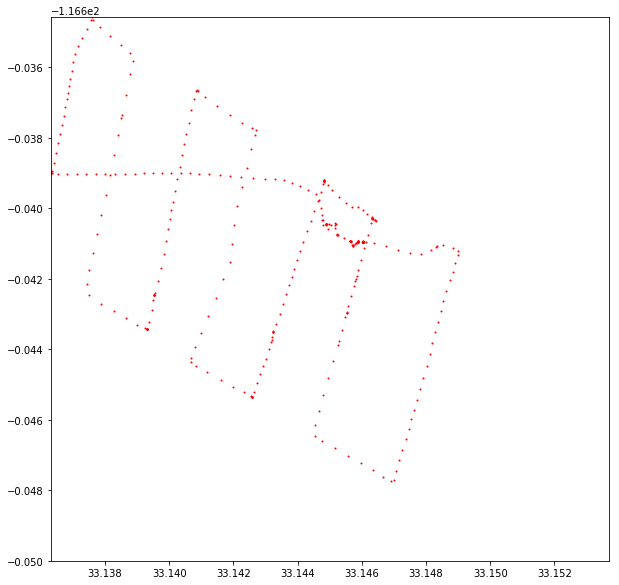

In [124]:
figdata = plt.figure(figsize=(10,10))  # create a figure object
ax = figdata.add_subplot(1, 1, 1)  # create an axes object in the figure
#ax.contour(lat_mesh, long_mesh, z.data, 10)
ax.scatter(lats,long, s=1, color="red")
plt.xlim(minlat, maxlat)
plt.ylim(-116.65, maxlong)
#figdata.savefig('test1.png', dpi=300)

In [10]:
# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(lat_mesh, long_mesh, z, filename="output.asc")



In [43]:
interval=(minn-maxx)/5
ls=[minn,minn+interval,minn+2*interval,minn+3*interval,minn+4*interval,minn+5*interval]

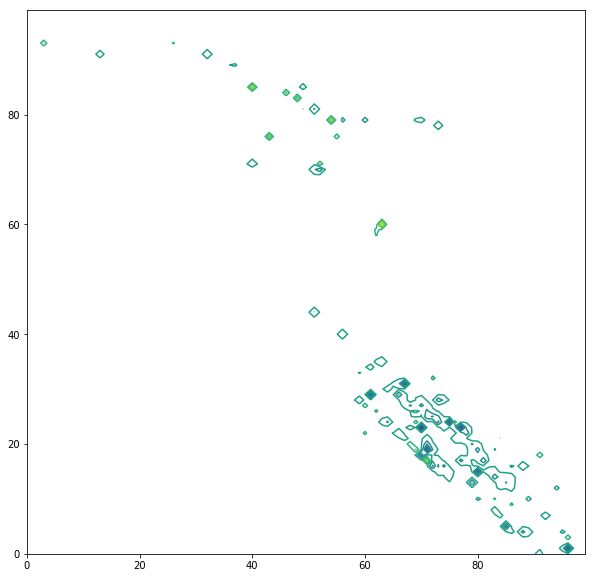

In [18]:
figdata0 = plt.figure(figsize=(10,10))  # create a figure object
ax0 = figdata0.add_subplot(1, 1, 1)
ax0.contour(z.data, levels=15)

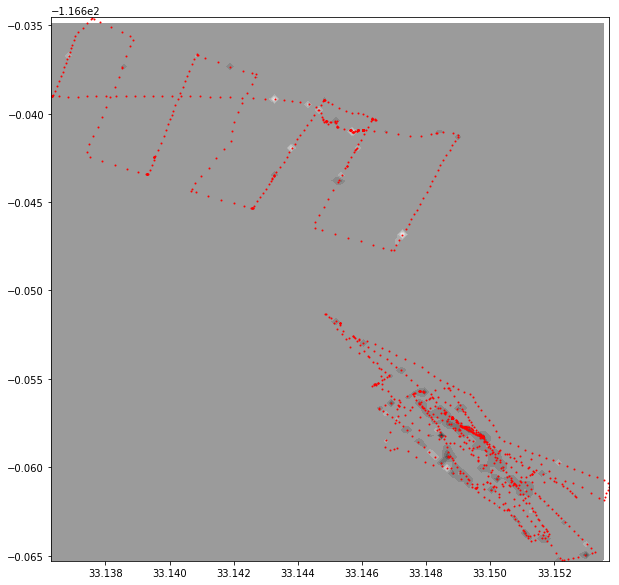

In [127]:
figdata1 = plt.figure(figsize=(10,10))  # create a figure object
ax1 = figdata1.add_subplot(1, 1, 1)
ax1.contourf(lat_mesh,long_mesh,z, levels=15, cmap='gray')
ax1.scatter(lats,long, s=1, color="red")



In [23]:
zmin = np.amin(z.data)
zmax = np.amax(z.data)

plt.imshow(z.data, cmap='hot', interpolation='nearest', norm=mcolors.Normalize) #vmax=zmax, vmin=zmin)
plt.show()

NameError: name 'mcolors' is not defined

In [101]:
coords = np.array(list(zip(lats, long)))

In [103]:
np.shape(coords)

(1081, 2)

In [104]:
# 2D Kring param opt

param_dict = {"method": ["ordinary", "universal"],
              "variogram_model": ["linear", "power", "gaussian", "spherical"],
              # "nlags": [4, 6, 8],
              # "weight": [True, False]
              }

estimator = GridSearchCV(Krige(), param_dict, verbose=True)

# dummy data
X = np.random.randint(0, 400, size=(100, 2)).astype(float)
y = 5 * np.random.rand(100)

# run the gridsearch
estimator.fit(X=coords, y=np.array(rf_freqs))


if hasattr(estimator, 'best_score_'):
    print('best_score R² = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)

print('\nCV results::')
if hasattr(estimator, 'cv_results_'):
    for key in ['mean_test_score', 'mean_train_score',
                'param_method', 'param_variogram_model']:
        print(' - {} : {}'.format(key, estimator.cv_results_[key]))

# 3D Kring param opt

param_dict3d = {"method": ["ordinary3d", "universal3d"],
              "variogram_model": ["linear", "power", "gaussian", "spherical"],
              # "nlags": [4, 6, 8],
              # "weight": [True, False]
              }

estimator = GridSearchCV(Krige(), param_dict3d, verbose=True)

# dummy data
X3 = np.random.randint(0, 400, size=(100, 3)).astype(float)
y = 5 * np.random.rand(100)

# run the gridsearch
estimator.fit(X=X3, y=y)


if hasattr(estimator, 'best_score_'):
    print('best_score R² = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)

print('\nCV results::')
if hasattr(estimator, 'cv_results_'):
    for key in ['mean_test_score', 'mean_train_score',
                'param_method', 'param_variogram_model']:
        print(' - {} : {}'.format(key, estimator.cv_results_[key]))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ign

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.1min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBack

best_score R² = -0.202
best_params =  {'method': 'ordinary', 'variogram_model': 'power'}

CV results::
 - mean_test_score : [ -0.24086266  -0.20158619  -0.30874653  -0.26439785  -0.58563036
 -36.33437955  -0.47625247  -0.31847317]
 - mean_train_score : [   0.92451751    0.92451741    0.92451766    0.92451921  -72.81001778
 -393.20676377  -11.64799352   -8.02203668]
 - param_method : ['ordinary' 'ordinary' 'ordinary' 'ordinary' 'universal' 'universal'
 'universal' 'universal']
 - param_variogram_model : ['linear' 'power' 'gaussian' 'spherical' 'linear' 'power' 'gaussian'
 'spherical']
Fitting 3 folds for each of 8 candidates, totalling 24 fits
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be 

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


# empirical cdf

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  


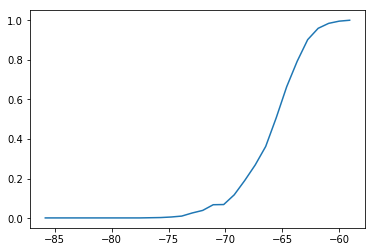

In [22]:
num_bins = 30
counts, bin_edges = np.histogram (rf_freqs, bins=num_bins, normed=False)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

In [23]:
for q in [50, 90, 95, 100]:
  print ("{}%% percentile: {}".format (q, np.percentile(rf_freqs, q)))

50%% percentile: -65.569461316
90%% percentile: -62.786619852
95%% percentile: -61.995500446
100%% percentile: -59.068270098
